In [734]:
%run matplotlib_setup.ipy
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
from wraparound import wraparound
from types import SimpleNamespace

# For computing eigenvalues
import scipy.sparse.linalg as sla

# For plotting
from matplotlib import pyplot

import scipy.linalg as la

import kwant

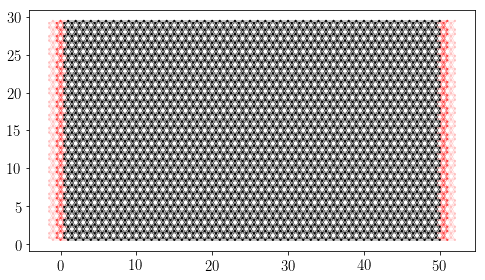

In [823]:
# Pauli matrices 
s0 = np.identity(2)
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.diag([1, -1])
layer1 = np.diag([1,0])
layer2 = np.diag([0,1])

lat = kwant.lattice.honeycomb(norbs=2)
a, b = lat.sublattices
nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b

sys = kwant.Builder()
L = 50
W = 30
t1 = 1.0
t2 = 1.0/3.0
r = 1.75
rtil = r/10.0
dz = t2*np.sqrt(3.0)*3.0
M1 = np.sqrt(3.0)/3#0.0*np.sqrt(3.0)/3.0
M2 = np.sqrt(3.0)*0.15#0.0*0.5
mu = 0.0
HG_nnn = 1j*t2*layer1
HG2_nnn = 1j*t2*layer2
HH_nnn = 1j*t2*s0
KM_nnn = 1j*t2*sz
newmodel_nnn = 1j*t2*s0 + 1j*t2*r/dz*sx
lead_volt = 0.001
frac = 1/4


def onsite(site): #interlayer hopping, Semenoff masses and chemical potential
    value = r*sx - mu*s0
    if site.family==a:
        value = value + M1*layer1 + M2*layer2
    if site.family==b:
        value = value - M1*layer1 - M2*layer2  
    return value

def onsite_lead1(site): #interlayer hopping and Semenoff masses
    value = mu*s0 + r*sx + lead_volt/2.0
    if site.family==a:
        value = value + M1*layer1 + M2*layer2
    if site.family==b:
        value = value - M1*layer1 - M2*layer2
    return value

def onsite_lead2(site): #interlayer hopping and Semenoff masses
    value = mu*s0 + r*sx -lead_volt/2.0
    if site.family==a:
        value = value + M2*s0#*layer2
    if site.family==b:
        value = value - M2*s0#*layer2
    return value

def rectangle(pos):
    x, y = pos
    return 0 < x < L and 0 < y < W

sys[lat.shape(rectangle, (1, 1))] = onsite
sys[lat.neighbors()] = t1*s0
sys[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = HH_nnn #+ rtil*1j*sx

sym = kwant.TranslationalSymmetry((-1, 0))
sym.add_site_family(lat.sublattices[0], other_vectors=[(-1, 2)])
sym.add_site_family(lat.sublattices[1], other_vectors=[(-1, 2)])

lead = kwant.Builder(sym)
lead1 = kwant.Builder(sym)
lead2 = kwant.Builder(sym)
lead3 = kwant.Builder(sym)
lead4 = kwant.Builder(sym)

def lead_shape(pos):
    x, y = pos
    return 0 < y < W

def lead_shape1(pos):
    x, y = pos
    return  0 < y < int(frac*W)

def lead_shape2(pos):
    x, y = pos
    return int(W-frac*W) < y < W

# Use this for band stuct etc.
lead[lat.shape(lead_shape, (1,1))] = onsite_lead1
lead[lat.neighbors()] = t1*s0
lead[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = HH_nnn #+ rtil*1j*sx

lead2[lat.shape(lead_shape, (1,1))] = onsite
lead2[lat.neighbors()] = t1*s0
lead2[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = HH_nnn #+ rtil*1j*sx

# Use this for transport
#lead[lat.shape(lead_shape, (1,1))] = onsite_lead2
#lead[lat.neighbors()] = t1*layer2
#lead[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = 1j*t2*layer2

lead1[lat.shape(lead_shape1, (1,1))] = onsite_lead1
lead1[lat.neighbors()] = t1*layer1
lead1[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = 1j*t2*layer1

#lead2[lat.shape(lead_shape2, (1,W))] = onsite_lead2
#lead2[lat.neighbors()] = t1*layer2

lead3[lat.shape(lead_shape2, (1,W))] = onsite_lead2
lead3[lat.neighbors()] = t1*layer1
#lead3[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = 1j*t2*layer1

lead4[lat.shape(lead_shape1, (1,1))] = onsite_lead1
lead4[lat.neighbors()] = t1*layer2



sys.attach_lead(lead)

sys.attach_lead(lead.reversed())

#sys.attach_lead(lead1)
#sys.attach_lead(lead3.reversed())
#sys.attach_lead(lead2)
#sys.attach_lead(lead4.reversed())

figrib=kwant.plot(sys);
figrib.savefig('ribbon.png')

In [451]:
#single = sys.finalized()
#ldos = kwant.ldos(single,0.2)
#kwant.plotter.map(single,ldos);

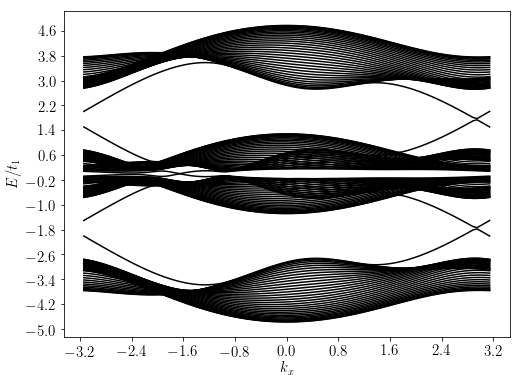

In [824]:
def plot_bands(sys):
    fsys = sys.finalized()
    params=dict(gamma=1., ep=0.)
    # Creating a new full window axes
    axval = plt.axes()
    xticks = np.arange(-3.2, 3.4, step=0.8)
    yticks = np.arange(-5.0, 5.2, step=0.8)
    axval.set_xticks(xticks)
    axval.set_yticks(yticks)
    axval.set_xlabel('$k_x$')
    axval.set_ylabel('$E/t_1$')
    kwant.plotter.bands(fsys.leads[1], momenta=98, params=params,fig_size=(12, 8),ax=axval) #Changing leads[0]->leads[1] flips BS
plot_bands(sys)
plt.savefig('M2_015_r_175.pdf')

In [779]:
#E = -7.5
#flead = lead.finalized()
#prop_modes, _ = flead.modes(energy=E)
#psi75 = prop_modes.wave_functions
news=sys.finalized()
eval=0.1
prop_modes, _ = news.leads[1].modes(energy=eval)
#print(prop_modes.wave_functions[10])
wf = kwant.wave_function(news, energy=eval)
print(prop_modes.momenta)
kval = 5
psi_L = wf(0)[18] #1st index is lead number (i.e. velocity direction) 2nd index is k index (incr)
psi_R = wf(1)[8]
print(prop_modes.momenta[kval])
#psi = prop_modes.wave_functions[0]
rho = kwant.operator.Density(news)
rho_sz = kwant.operator.Density(news, sz)
rho_1 = kwant.operator.Density(news, layer1)
rho_2 = kwant.operator.Density(news, layer2)

[-3.10623952 -3.09106267 -3.04037648 -3.02574898 -2.99215236 -2.9854563
 -2.96388594 -2.9623397  -2.49923655 -0.19262717 -0.17077392 -0.13209148
 -0.07263197  0.01474659  0.14388408  0.3469972   0.72760901  1.03914315
  1.26808028  1.34230428  1.45169338  1.49736063  1.52070554  1.6654123
  1.77242068  1.8636205   1.94881956  2.03381334  2.12313726  2.22165541
  2.33665116  2.48408965  2.74564718  2.87868306  2.97672992  3.07130621
  3.09445594  3.02850308  2.64989874  2.52470833  2.40820585  2.38004523
  2.31725331  2.28636078  2.23947038  2.22995883  2.18975649  2.18921128
  2.16409442  2.16322056  0.59896378  0.32692874  0.20418573  0.13397372
  0.09652238 -2.31304301 -2.6904872  -2.69093314 -2.70552595 -2.70813904
 -2.72966266 -2.73777407 -2.76294742 -2.77801024 -2.80978046 -2.82178088
 -2.86607372 -2.88041858 -2.91308159 -2.94404447 -2.98259947 -3.00352315
 -3.01858276 -3.02942595]
-2.9854563031501895


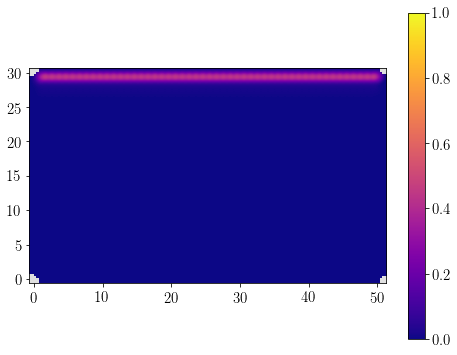

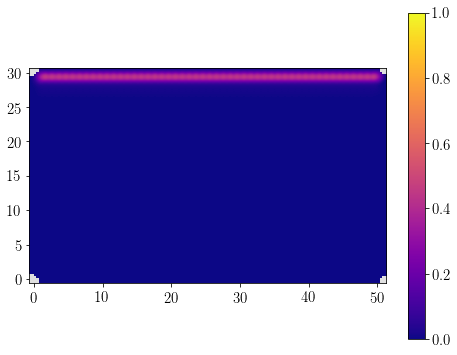

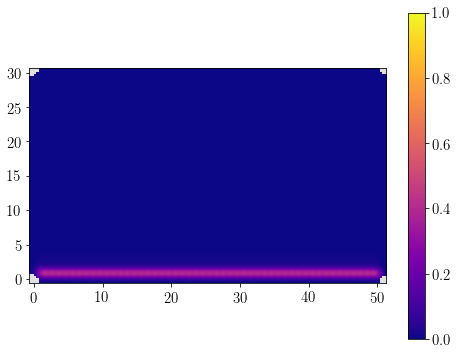

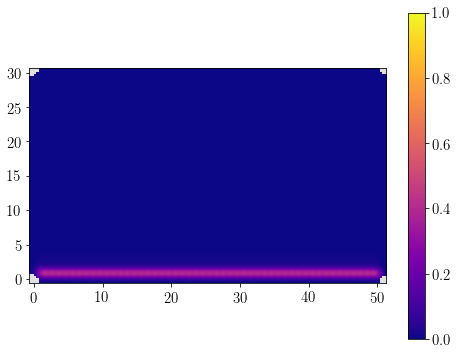

In [807]:
density_L = rho(psi_L)
sigz_L = rho_sz(psi_L)
dens1_L = rho_1(psi_L)
dens2_L = rho_2(psi_L)
density_R = rho(psi_R)
sigz_R = rho_sz(psi_R)
dens1_R = rho_1(psi_R)
dens2_R = rho_2(psi_R)
#kwant.plotter.density(news, density)
plt1 = kwant.plotter.density(news, dens1_L, vmin=0.0, vmax=1.0, cmap='plasma')#+dens1_R)
plt1.savefig('edge_densR1.pdf')
plt2=kwant.plotter.density(news, dens2_L, vmin=0.0, vmax=1.0, cmap='plasma')#+dens2_R)
plt2.savefig('edge_densR2.pdf')
plt3=kwant.plotter.density(news, dens1_R, vmin=0.0, vmax=1.0, cmap='plasma')#+dens1_R)
plt3.savefig('edge_densL1.pdf')
plt4=kwant.plotter.density(news, dens2_R, vmin=0.0, vmax=1.0, cmap='plasma')#+dens2_R)
plt4.savefig('edge_densL2.pdf')

J_0 = kwant.operator.Current(news)
J_1 = kwant.operator.Current(news, layer1)
J_2 = kwant.operator.Current(news, layer2)
current0_L = J_0(psi_L)
current1_L = J_1(psi_L)
current2_L = J_2(psi_L)
current0_R = J_0(psi_R)
current1_R = J_1(psi_R)
current2_R = J_2(psi_R)
#kwant.plotter.current(news, current0_L+current0_R)
#kwant.plotter.current(news, current1_L+current1_R)
#kwant.plotter.current(news, current2_L+current2_R)

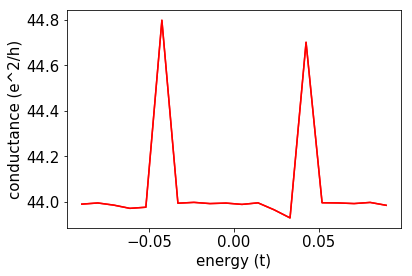

In [396]:
def plot_conductance(sys, energies):
    fsys = sys.finalized()
    data00 = []
    data01 = []
    data02 = []
    data03 = []
    data10 = []
    data11 = []
    data12 = []
    data13 = []
    data23 = []
    
    datasum = []
    datadiff=[]
    ratio=[]
    shot=[]

    for energy in energies:
        smatrix = kwant.smatrix(fsys, energy)
        data00.append(smatrix.transmission(0, 0))
        data01.append(smatrix.transmission(0, 1))
        #data02.append(smatrix.transmission(0, 2))
        #data03.append(smatrix.transmission(0, 3))
        data10.append(smatrix.transmission(1, 0))
        data11.append(smatrix.transmission(1, 1))
       # data12.append(smatrix.transmission(1, 2))
       # data13.append(smatrix.transmission(1, 3))
       # data23.append(smatrix.transmission(2, 3))
        #shot.append(kwant.physics.two_terminal_shotnoise(smatrix))
        #data2.append(smatrix.transmission(2, 0))
       # sumval=smatrix.transmission(3, 2)+smatrix.transmission(1, 0)+smatrix.transmission(1, 2)+smatrix.transmission(3, 0)
       # diffval=smatrix.transmission(3, 2)+smatrix.transmission(1, 0)-smatrix.transmission(1, 2)-smatrix.transmission(3, 0)
       # datasum.append(sumval)
       # datadiff.append(diffval)
       # ratio.append(diffval/sumval)
        
    plt.figure()
    #plt.plot(energies, data00, color='blue')
    plt.plot(energies, data01, color='Red')
    #plt.plot(energies, data02, color='Orange')
    #plt.plot(energies, data03, color='Green')
    plt.plot(energies, data10, color='Red')
    #plt.plot(energies, data23, color='Purple')
    #plt.plot(energies, shot, color='red')
   # plt.plot(energies, data2,color='orange')
  #  plt.plot(energies, datasum,color='green')
    plt.xlabel("energy (t)")
    plt.ylabel("conductance (e^2/h)")
    plt.show()
    
Es = np.linspace(-0.09,0.09, 20)
plot_conductance(sys, Es)

In [794]:
for i in range(0,9199,2):
    if np.abs(psi_L[i])**2>0.1:
        print(psi_L[i] ,psi_L[i+1])

(0.05205397878828938-0.32136095707537876j) (-0.02278922774761685+0.18741321086289564j)
(0.44357862399845194-0.13694497297780975j) (-0.12598875091217368-0.08124830187602397j)
(0.5128363609609758+0.1950943128168769j) (-0.4969592450193197-0.2577490864838741j)
(-0.3365421175452596-0.17106901160810253j) (0.346448946068196+0.12270806452907498j)
(-0.3874692256811377+0.2836989188987538j) (0.47418085218060263-0.3032265933755614j)
(-0.45586744401884166-0.13857318326995097j) (0.5466983277079619+0.13744246105619132j)
(-0.30626178934399895+0.08064518239268617j) (0.34034898811781944-0.031379244528099204j)
(-0.31007454364567516+0.1428000875340444j) (0.3440835920346401-0.12925443886289867j)
(-0.5532045484359759+0.016456690869283083j) (0.5545494387474572+0.06745877525409907j)
(0.2480915669929204-0.4832142036574582j) (-0.21254073152152736+0.5247265417862037j)
(-0.29685467780855784+0.41834371764761524j) (0.2577704212278097-0.40740955208973817j)
(-0.15408501965034413+0.35455623972492517j) (0.1644124244515

Let's do this with two different lattices:

In [607]:
lat_h = kwant.lattice.honeycomb(1, name='h')
lat_g = kwant.lattice.honeycomb(1, name='g')
ah, bh = lat_h.sublattices
ag, bg = lat_g.sublattices

nnn_hoppings_ah = (((-1, 0), ah, ah), ((0, 1), ah, ah), ((1, -1), ah, ah))
nnn_hoppings_bh = (((1, 0), bh, bh), ((0, -1), bh, bh), ((-1, 1), bh, bh))
nnn_hoppings_h = nnn_hoppings_ah + nnn_hoppings_bh
nnn_hoppings_ag = (((-1, 0), ag, ag), ((0, 1), ag, ag), ((1, -1), ag, ag))
nnn_hoppings_bg = (((1, 0), bg, bg), ((0, -1), bg, bg), ((-1, 1), bg, bg))
nnn_hoppings_g = nnn_hoppings_ag + nnn_hoppings_bg

sys = kwant.Builder()
L = 30
W = 20
r = 15.0
t1 = 1.0
t2 = 1.0/3.0
M1 = 0.0*np.sqrt(3.0)/3.0
M2 = 0.0*M1
mu = -15


def onsite_h(site): #Semenoff masses and chemical potential
    if site.family==ah:
        value = -mu + M1
    if site.family==bh:
        value = -mu - M1 
    return value

def onsite_g(site): #Semenoff masses and chemical potential
    if site.family==ag:
        value = -mu + M2
    if site.family==bg:
        value = -mu - M2 
    return value

def onsite_lead1(site): #interlayer hopping and Semenoff masses
    value = 0
    if site.family==a:
        value = value + M1*layer1
    if site.family==b:
        value = value - M1*layer1 
    return value

def onsite_lead2(site): #interlayer hopping and Semenoff masses
    value = 0
    if site.family==a:
        value = value + M2*layer2
    if site.family==b:
        value = value - M2*layer2
    return value

def rectangle(pos):
    x, y = pos
    return 0 < x < L and 0 < y < W


sys[lat_h.shape(rectangle, (1, 1))] = onsite_h
sys[lat_h.neighbors()] = t1
sys[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings_h]] = 1j*t2

sys[lat_g.shape(rectangle, (1, 1))] = onsite_g
sys[lat_g.neighbors()] = t1

sys[(lat_h.shape(rectangle, (1, 1)), lat_g.shape(rectangle, (1, 1)))] = r
#sys[((lat_g(x, y), lat_h(x, y)) for sublattice in lat_h.sublattices for x in range(L) for y in range(W))] = r

sym = kwant.TranslationalSymmetry((-1, 0))
sym.add_site_family(lat_h.sublattices[0], other_vectors=[(-1, 2)])
sym.add_site_family(lat_h.sublattices[1], other_vectors=[(-1, 2)])

lead_h = kwant.Builder(sym)
lead_g = kwant.Builder(sym)

def lead_shape(pos):
    x, y = pos
    return 0 < y < W

# Use this for transport
lead_h[lat_h.shape(lead_shape, (1,1))] = onsite_h
lead_h[lat_h.neighbors()] = t1
lead_h[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings_h]] = 1j*t2

lead_g[lat_h.shape(lead_shape, (1,1))] = onsite_g
lead_g[lat_h.neighbors()] = t1


sys.attach_lead(lead_h)
sys.attach_lead(lead_h.reversed())
sys.attach_lead(lead_g.reversed())

kwant.plot(sys);

TypeError: Hopping elements must be Site objects, not function.